In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os

from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *
np.random.seed(constants.SEEDS[3])


In [2]:
nS = 20
nrows = 20
num_bins = 10
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
#experiment_name = f"RiverSwim{nS}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='mlflow-artifacts:/260080021947951050', creation_time=1717315829184, experiment_id='260080021947951050', last_update_time=1717315829184, lifecycle_stage='active', name='FrozenLake_20x20_10', tags={}>

In [3]:
results = get_parent_artifacts(experiment_id=experiment_id)

[<Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'CurrPMPO_10',
 'mlflow.source.name': 'c:\\Users\\crist\\OneDrive - Politecnico di '
                       'Milano\\Polimi\\Tesi\\TMDP\\env_mlflow\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'crist'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/260080021947951050/fc66e2b8139d407697494f9c73910f85/artifacts', end_time=None, experiment_id='260080021947951050', lifecycle_stage='active', run_id='fc66e2b8139d407697494f9c73910f85', run_name='CurrPMPO_10', run_uuid='fc66e2b8139d407697494f9c73910f85', start_time=1717430080050, status='RUNNING', user_id='crist'>, inputs=<RunInputs: dataset_inputs=[]>>, <Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'CurrPPO_10',
 'mlflow.source.name': 'c:\\Users\\crist\\OneDrive - Politecnico di '
                       'Milano\\Polimi\\Tesi\\TMDP\\env_mlflow\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.t

Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmp2z6owexc\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=6034144, is_dir=False, path='results.pth'>, <FileInfo: file_size=31427, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpyfw9fj22\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=2978016, is_dir=False, path='results.pth'>, <FileInfo: file_size=36674, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpmgg55u7m\results.pth
Dictionary loaded from MLflow


In [4]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter

In [5]:
def plot_experiment_results(results, title=None, figsize=(8, 5), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False, x_scale:int=500):
    plt.close('all')
    rew = [r["tests_rewards"] for r in results]
    reduced_len = np.min([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)

    title = "Average Return" if title is None else title
    for i, result in enumerate(results):
        rewards = result["tests_rewards"]
        label = result["label"]
        avg_rewards = np.average(rewards, axis=0)
        if reduce:
            avg_rewards = avg_rewards[:reduced_len]

        x_values = np.arange(len(avg_rewards)) * x_scale
        ax.plot(x_values, avg_rewards, label=label, c=COLORS[i], marker = MARKERS[i%len(MARKERS)],
                markevery=MARKER_FREQUENCY[i%len(MARKER_FREQUENCY)],
                linestyle=LINE_STYLES[i%len(LINE_STYLES)],
                )
        
        if conf_int:
            std_dev = np.std(rewards, axis=0)
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(rewards)
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_rewards + ci * std_err
            lower_bound = avg_rewards - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS[i], alpha=0.2)
    
   
    ax.legend(loc="lower right", framealpha=1.)
    ax.set_title(title)
    ax.set_xlabel('Million Episodes')
    ax.set_ylabel('Avg Return')
    ax.grid()
    plt.show()
    return fig


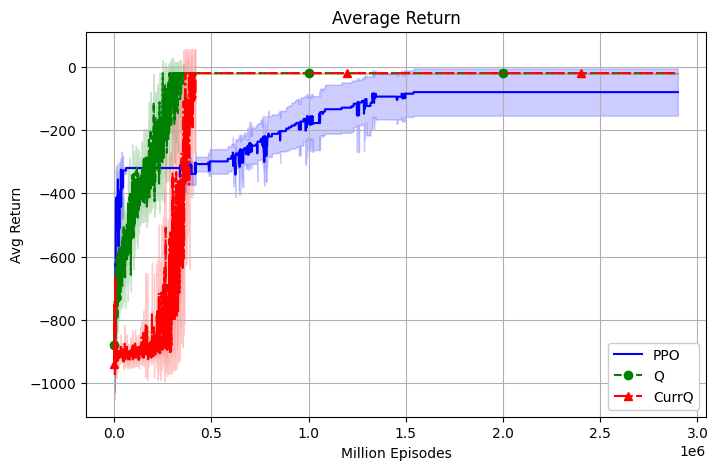

In [6]:
fig = plot_experiment_results(results, reduce=True, conf_int=True)
